# scAnnot

> Single-cell large-scale automatic hierarchical annotation

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import numpy as np
import scanpy as sc
import scvi
from fastcore.script import *
import warnings

import logging
import colorlog

# Create a logger
logger = logging.getLogger('my_logger')
logger.setLevel(logging.DEBUG)
#logging.getLogger().setLevel(logging.INFO)

# Create a colorlog formatter
formatter = colorlog.ColoredFormatter(
    '%(log_color)s%(levelname)s:%(name)s:%(message)s',
    log_colors={
        'DEBUG': 'cyan',
        'INFO': 'black',
        'WARNING': 'yellow',
        'ERROR': 'red',
        'CRITICAL': 'red,bg_white',
    }
)

# Create a console handler and set the formatter
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)

# Add the console handler to the logger
logger.addHandler(console_handler)

## generate 1 cell ref

In [ ]:
adata=sc.read('../../scBERT/data/whole_brain_sub_genes_overlap_with_other_dataset.h5ad')
adata.layers["counts"] = adata.X

In [ ]:
import anndata as ad

In [ ]:
ref=ad.AnnData(adata.X.getrow(0),var=adata.var)

In [ ]:
ref

AnnData object with n_obs × n_vars = 1 × 1841
    var: 'Accession', 'Gene', 'Valid', 'uniqeID'

In [ ]:
ref.var

,Accession,Gene,Valid,uniqeID
uniqeID,,,,
A2M,ENSG00000175899.15,A2M,1,A2M
AACS,ENSG00000081760.17,AACS,1,AACS
AAK1,ENSG00000115977.19,AAK1,0,AAK1
AASS,ENSG00000008311.15,AASS,1,AASS
AATK,ENSG00000181409.14,AATK,1,AATK
...,...,...,...,...
ZNF704,ENSG00000164684.13,ZNF704,0,ZNF704
ZNF710,ENSG00000140548.10,ZNF710,1,ZNF710
ZNF804A,ENSG00000170396.9,ZNF804A,1,ZNF804A


In [ ]:
ref.write_h5ad('/home/huang_yin/projA/scBERT/model/reference_genes.h5ad')

## Functions

In [ ]:
#| hide
# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/00_core.ipynb.

# %% auto 0
__all__ = ['scAnnot']

# %% ../nbs/00_core.ipynb 4
import numpy as np
import scanpy as sc
import scvi
from fastcore.script import *
import warnings

# %% ../nbs/00_core.ipynb 13
@call_parse
def scAnnot(h5:str, #the input h5ad file, must have row counts in X or layers
            output:str = None, # The path of output file. 1. None->output AnnData object with predicted labels, 2. a path end with h5ad->write out the AnnData. 3. a path end with csv-> write out the table of predicted labels. 
            show:bool=False, #show umap plot. may not work in command line
           ):
    warnings.filterwarnings("ignore")
    ad=sc.read(h5)
   
    if 'counts' not in ad.layers.keys():
        ad.layers['counts']=ad.X
    arr=ad.layers['counts'].data
    if not np.array_equal(arr, np.round(arr)):
        raise logger.error("Not all counts are integers")
    
    #concatenate query and ref
    ref=sc.read('/home/huang_yin/projA/scBERT/model/reference_genes.h5ad')
    ad=ad[:,ad.var.index.isin(ref.var.index)]
    print(f'{ad.shape[1]} of genes are found in ref genes (total {ref.shape[1]}). The percentage is {ad.shape[1]/ref.shape[1]}')
    ad=ad.concatenate(ref,join='outer')[1:] #remove ref cell
    if not ad.var.index.equals(ref.var.index):
        raise logger.error("The order of gene are not the same between query and reference")
    model=scvi.model.SCANVI.load_query_data(
            ad,
            '/home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/',
            freeze_dropout = True,
            inplace_subset_query_vars = True,
        )
    
    ad.obs['predict_level1']=model.predict()
    
    if show:
        model.is_trained=True
        latent=sc.AnnData(model.get_latent_representation())
          
    ad.obs['predict_level2']='unknown'
    for i in ad.obs['predict_level1'].unique():
        sub_ad=ad[ad.obs.predict_level1==i]
        model=scvi.model.SCANVI.load_query_data(
            sub_ad,
            f'/home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_{i}/',
            freeze_dropout = True,
            inplace_subset_query_vars = True,
        )
        ad.obs['predict_level2'][ad.obs.predict_level1==i]=model.predict()
    if show:
        latent.obs['predict_level1']=ad.obs['predict_level1'].tolist()
        latent.obs['predict_level2']=ad.obs['predict_level2'].tolist()
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        sc.pl.umap(latent,color=['predict_level1', 'predict_level2'],frameon=False)
       
    if output is not None:
        if output.endswith('.csv'):
            ad.obs[['predict_level1','predict_level2']].to_csv(output)
            return
        if output.split('.')[-1] in ['h5ad','h5']:
            ad.write_h5ad(output)
            return
    return ad



In [ ]:
#| export
@call_parse
def scAnnot(input:str, #the input h5ad file, must have row counts in X or layers
            reference:str, #the reference h5ad file
            model_dir:str, #The path to the directory containing trained SCANVI models
            output:str = None, # The path of output file. 1. None->output AnnData object with predicted labels, 2. a path end with h5ad->write out the AnnData. 3. a path end with csv-> write out the table of predicted labels. 
            show:bool=False, #show umap plot. may not work in command line
           ):
    warnings.filterwarnings("ignore")
    if isinstance(input, str):
        input=Path(input)
        logger.info(f'Reading input file: {input}')
        ad=sc.read(input)
    elif isinstance(fin, AnnData):
        ad=input
    else:
        raise logger.error("Invalid input format. Anndata file path or Anndata object.")

    #make sure ad.X have data and is dense matrix
    if ad.shape[0]<1 or ad.shape[1]<1:
        raise logger.error("The anndata don't have cells or genes")
    if issparse(ad.X):
        ad.X.eliminate_zeros() #remove potential 0s.
        if not isspmatrix_csr(ad.X):
            ad.X = csr_matrix(ad.X)
    else:
        ad.X = csr_matrix(ad.X)
   
    if 'counts' not in ad.layers.keys():
        ad.layers['counts']=ad.X

    #Check if the data are integers
    arr=ad.layers['counts'].data
    if not np.array_equal(arr, np.round(arr)):
        raise logger.error("Not all counts are integers")
        
    ad=scannot(ad,reference,model_dir,output,show)
    
    return ad
    
    
    
 

    
    
    model=scvi.model.SCANVI.load_query_data(
            ad,
            '/home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/',
            freeze_dropout = True,
            inplace_subset_query_vars = True,
        )
    
    ad.obs['predict_level1']=model.predict()
    
    if show:
        model.is_trained=True
        latent=sc.AnnData(model.get_latent_representation())
          
    ad.obs['predict_level2']='unknown'
    for i in ad.obs['predict_level1'].unique():
        sub_ad=ad[ad.obs.predict_level1==i]
        model=scvi.model.SCANVI.load_query_data(
            sub_ad,
            f'/home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_{i}/',
            freeze_dropout = True,
            inplace_subset_query_vars = True,
        )
        ad.obs['predict_level2'][ad.obs.predict_level1==i]=model.predict()
    if show:
        latent.obs['predict_level1']=ad.obs['predict_level1'].tolist()
        latent.obs['predict_level2']=ad.obs['predict_level2'].tolist()
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        sc.pl.umap(latent,color=['predict_level1', 'predict_level2'],frameon=False)
       
    if output is not None:
        if output.endswith('.csv'):
            ad.obs[['predict_level1','predict_level2']].to_csv(output)
            return
        if output.split('.')[-1] in ['h5ad','h5']:
            ad.write_h5ad(output)
            return
    return ad


In [ ]:
def scannot(adata: sc.AnnData, 
            ref_data: str,
            model_dir: str,
            output: str = None,
            show_latent: bool = False) -> sc.AnnData:
    """
    Perform single-cell RNA-seq annotation using scAnnot.
    
    Parameters:
    adata: AnnData object containing single-cell expression data
    ref_data: Path to reference AnnData object
    model_dir: Directory containing trained SCANVI models in the follwing structure
                /root
                ├── model.pt
                ├── L1_celltype1
                │   ├── model.pt
                │   ├── L2_celltype2
                │   │   ├── model.pt
                │   ├── L2_celltype3
                │   │   ├── model.pt
                ├── L1_celltype2
                │   ├── model.pt
                ├── L1_celltype3
                │   ├── model.pt

    output: Path to save annotated data (default None to return AnnData)
    show_latent: Bool to visualize latent space (default False)
    
    Performs preprocessing, Level 1 annotation with primary cell types,
    Level 2 annotation with subtypes, and saves/returns annotated data.
    """
    
    # Load data and reference 
    adata = preprocess_data(adata, ref_data)
    
    # Perform multi-level annotation
    adata = annotate_levels(adata, model_dir)
    
    if show_latent:
        latent = get_latent_representation(adata)
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        sc.pl.umap(latent,color=latent.obs.filter(regex=r'^level'),frameon=False)
    
    if output:
        save_results(adata, output)
        
    return adata

In [ ]:
#| export
def scannot(adata: sc.AnnData, 
            ref_data: str,
            model_dir: str,
            output: str = None,
            show_latent: bool = False) -> sc.AnnData:
    """
    Perform single-cell RNA-seq annotation using scAnnot.
    
    Parameters:
    adata: AnnData object containing single-cell expression data
    ref_data: Path to reference AnnData object
    model_dir: Directory containing trained SCANVI models in the follwing structure
                /root
                ├── model.pt
                ├── L1_celltype1
                │   ├── model.pt
                │   ├── L2_celltype2
                │   │   ├── model.pt
                │   ├── L2_celltype3
                │   │   ├── model.pt
                ├── L1_celltype2
                │   ├── model.pt
                ├── L1_celltype3
                │   ├── model.pt

    output: Path to save annotated data (default None to return AnnData)
    show_latent: Bool to visualize latent space (default False)
    
    Performs preprocessing, Level 1 annotation with primary cell types,
    Level 2 annotation with subtypes, and so on.
    """
    
    # Load data and reference 
    adata = preprocess_data(adata, ref_data)
    
    level=get_max_depth(model_dir)
    # Perform multi-level annotation
    if level==1:
        adata = annotate_level1(adata, model_dir)
    elif level==2:
        adata = annotate_level1(adata, model_dir)
        adata = annotate_level2(adata, model_dir)
    else:
        adata = annotate_levels(adata, model_dir)
    
    if show_latent:
        latent = get_latent_representation(adata)
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        sc.pl.umap(latent,color=latent.obs.filter(regex=r'^level'),frameon=False)
    
    if output:
        save_results(adata, output)
        
    return adata


def preprocess_data(adata, ref_data):
    """
    Preprocess single-cell data before annotation.
    
    Parameters:
    
    adata: AnnData object containing single-cell expression data
    ref_data: Path to reference AnnData object
    
    Filters adata to common genes with reference, concatenates datasets,
    and applies any normalization/filtering as preprocessing steps.
    
    Returns preprocessed AnnData object.
    """
  
    ref = sc.read(ref_data)[:1].copy() #Only keep the first cell 
    
    # Filter adata to common genes with ref
    adata = adata[:, adata.var.index.isin(ref.var.index)]  
    logger.info(f'{adata.shape[1]} of genes are found in reference (total {ref.shape[1]}). The percentage is {adata.shape[1]/ref.shape[1]}')
    
    # Check for counts
    if 'counts' not in adata.layers:
        raise logger.error("Counts layer missing")
    
    # Concatenate datasets  
    adata = adata.concatenate(ref, join='outer')[1:]# Remove the reference cell  

    if not adata.var.index.equals(ref.var.index):
        raise logger.error("The order of gene are not the same between query and reference")
    
    # Optional - log normalization etc
    # sc.pp.normalize_total(adata)

    return adata

def annotate_level1(adata, model_dir):

    model = scvi.model.SCANVI.load_query_data(
        adata, model_dir,freeze_dropout = True,inplace_subset_query_vars = True)
    
    predictions = model.predict()
    adata.obs['level1'] = predictions
    
    return adata

def annotate_level2(adata, model_dir):

    obs=adata.obs.copy()
    obs['level2']='unknown'
    
    for cell_type in adata.obs['level1'].unique():
        
        idx = adata.obs['level1'] == cell_type
        subdata = adata[idx]  
        try:
            model = scvi.model.SCANVI.load_query_data(
                subdata, f"{model_dir}/{cell_type}",freeze_dropout = True,inplace_subset_query_vars = True)
            
            predictions = model.predict()
            obs['level2'][idx] = predictions
        except:
            #print warning
            obs['level2'][idx] =cell_type
            
    adata.obs=obs
    return adata


def get_latent_representation(adata, model_dir):

    model = scvi.model.SCANVI.load_query_data(
        adata, model_dir,freeze_dropout = True,inplace_subset_query_vars = True)
    model.is_trained=True
    
    latent = sc.AnnData(model.get_latent_representation())
    return latent
    
def save_results(adata, output):
    """
    Save annotated data to file.
    
    Parameters:
    
    adata: Annotated AnnData object
    output: Path to save data
    Saves annotations to CSV or H5AD file format.
    """

    if output.endswith(('.csv', '.txt')):
        adata.obs.filter(regex=r'^level').to_csv(output)
    
    elif output.endswith('.h5ad'):  
        adata.write(output)

    else:
        adata.obs.filter(regex=r'^level').to_csv(output+'.csv')

In [ ]:
#| export
def annotate_levels(adata, model_dir):
    """
    Perform multi-level annotation using pretrained models.
    
    Parameters:
    - adata: AnnData containing expression data  
    - model_dir: Directory with model files organized by level
    - output: Path to save annotations
    
    Annotates data at all levels recursively and saves annotations.
    
    Performs level 1 annotation, then recursively calls 
    annotate_deeper_levels() to annotate deeper levels.
    """
    
    # Level 1 annotation 
    model = load_model(adata, os.path.join(model_dir, 'model.pt'))
    annotate_level(adata, model, 1)
    
    # Recursively annotate deeper levels
    annotate_deeper_levels(adata, model_dir, 2)
    
    return adata

def annotate_deeper_levels(adata, model_dir, level):
    """
    Annotate deeper levels recursively.
    
    Parameters:
    - adata: Annotated AnnData
    - model_dir: Directory with model files 
    - level: Current annotation level  
    
    For each annotation at current level:
    - Filters data
    - Loops through subdirectories as next level
    - Loads and runs appropriate model
    - Annotates and recursively calls on subset
    
    This allows annotating arbitrary nested levels.
    """
    current_level = f'level{level}'
    
    for annotation in adata.obs[current_level].unique():
    
        subdata = adata[adata.obs[current_level] == annotation]
        
        if os.path.exists(os.path.join(model_dir, annotation)):
          
            for deeper_annotation in os.listdir(os.path.join(model_dir, annotation)):
            
                model = load_model(os.path.join(model_dir, annotation, 
                                                deeper_annotation, f'level{level+1}.pt'))
                                                
                annotate_level(subdata, model, level+1, idx)
                                                      
                annotate_deeper_levels(subdata, os.path.join(model_dir, annotation), level+1)

def annotate_level(adata, model, level,idx):
    """
    Annotate adata at a single level.
    
    Parameters:
    - adata: AnnData to annotate
    - model: Trained SCANVI model  
    - level: Annotation level 
    - idx: cell index
    
    Runs model predictions and annotates observations
    with predictions at the given level.
    """
    predictions = model.predict()
    adata.obs[f'level{level}'][idx] = predictions

def load_model(adata,md):
    model = scvi.model.SCANVI.load_query_data(
        adata, md,freeze_dropout = True,inplace_subset_query_vars = True)
    return model

In [ ]:
import torch
torch.cuda.set_device(1)
print(torch.cuda.current_device())

1


1834 of genes are found in ref genes (total 1841). The percentage is 0.9961977186311787
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/model.pt already     
         downloaded                                                                                                
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Miscellaneous/model.pt  
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Splatter/model.pt       
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Amygdala                
         excitatory/model.pt already downloaded                                                     

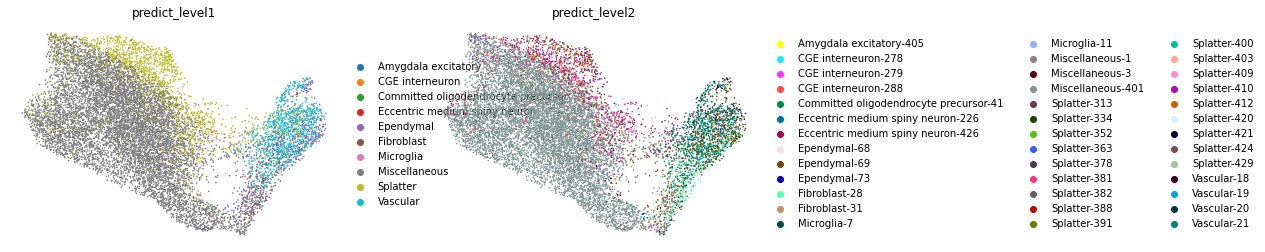

In [ ]:
ad=scAnnot('/home/huang_ziliang/project/brain/data/public/human_brain_CorticalOrganoids_Ziffra_2021_ATAC-seq_10x/h5/VitACtrlDEAB_umap.h5ad',show=True)

In [ ]:
ad=scAnnot('/home/huang_ziliang/project/brain/data/public/human_brain_Hippocampus_Su_2022_10x/h5/meta_umap.h5ad',show=True)

1795 of genes are found in ref genes (total 1841). The percentage is 0.9750135795763172
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/model.pt already     
         downloaded                                                                                                
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Amygdala                
         excitatory/model.pt already downloaded                                                                    
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Oligodendrocyte         
         precursor/model.pt already downloaded                                                                     
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_MGE interneuron/model.pt
         already downloaded                                                                         

INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/model.pt already     
         downloaded                                                                                                
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Splatter/model.pt       
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Vascular/model.pt       
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Ependymal/model.pt      
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes

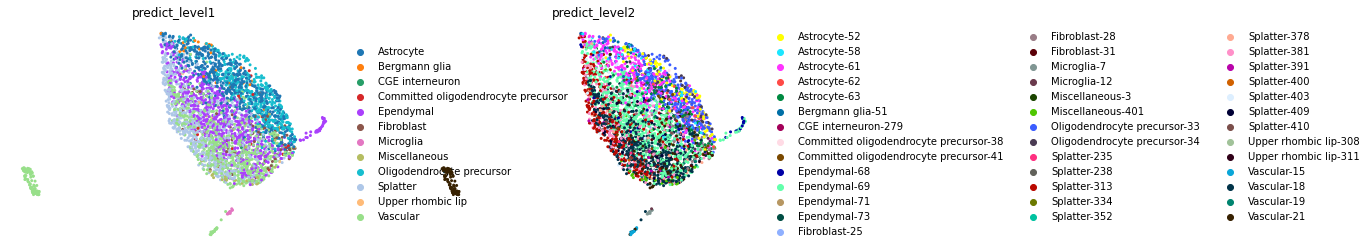

In [ ]:
ad=scAnnot('/home/huang_ziliang/project/brain/data/public/human_brain_glial_Fu_2021_PCR/h5/umap.h5ad',show=True)

In [ ]:
ad

AnnData object with n_obs × n_vars = 3355 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'original_name', 'cell_ID', 'seq_tech', 'species', 'organ', 'seq_method', 'sample_type', 'project_code', 'reference', 'ethnicity', 'region', 'subregion', 'donor_age', 'donor_status', 'sample_status', 'treatment', 'if_patient', 'donor_gender', 'original_name2', 'donor_ID', 'sample_ID', '_scvi_batch', 'celltype_scanvi', '_scvi_labels', 'predict_level1', 'predict_level2'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/model.pt already     
         downloaded                                                                                                
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Committed               
         oligodendrocyte precursor/model.pt already downloaded                                                     
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Astrocyte/model.pt      
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Oligodendrocyte         
         precursor/model.pt already downloaded                                                                     
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes

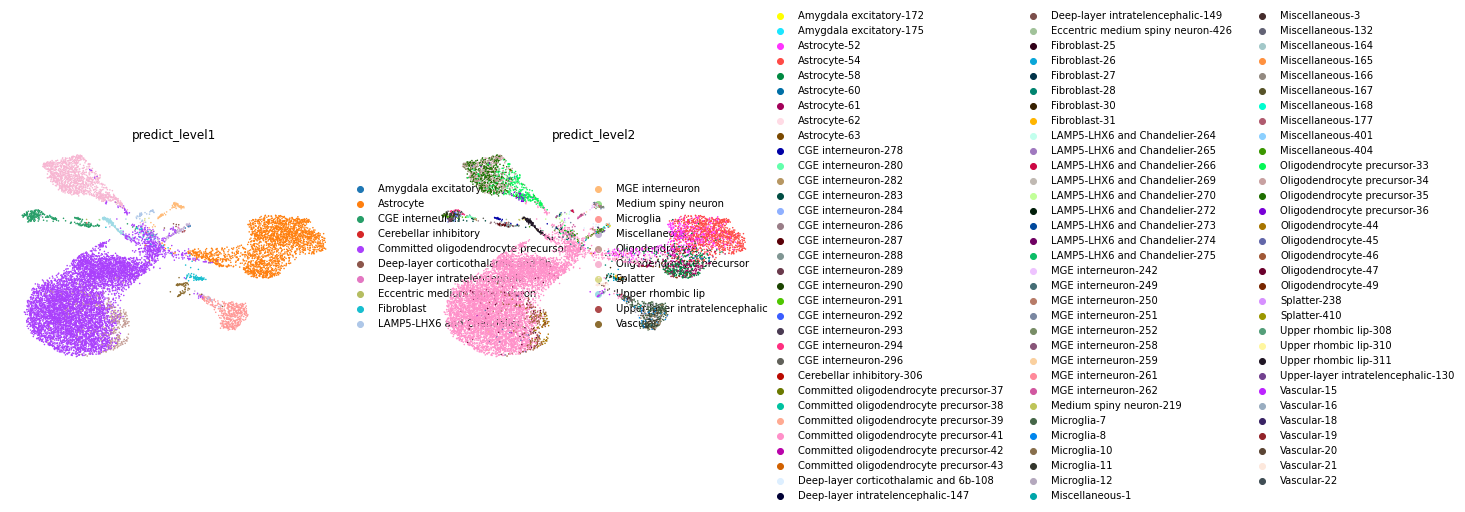

In [ ]:
ad=scAnnot('/home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/umap.h5ad',show=True)

INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/scanvi_3_epoch_model/model.pt already     
         downloaded                                                                                                
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_CGE interneuron/model.pt
         already downloaded                                                                                        
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Upper-layer             
         intratelencephalic/model.pt already downloaded                                                            
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes/v1_scanvi_subtype_Committed               
         oligodendrocyte precursor/model.pt already downloaded                                                     
INFO     File /home/huang_yin/projA/scBERT/model/twostep_2layer_subgenes

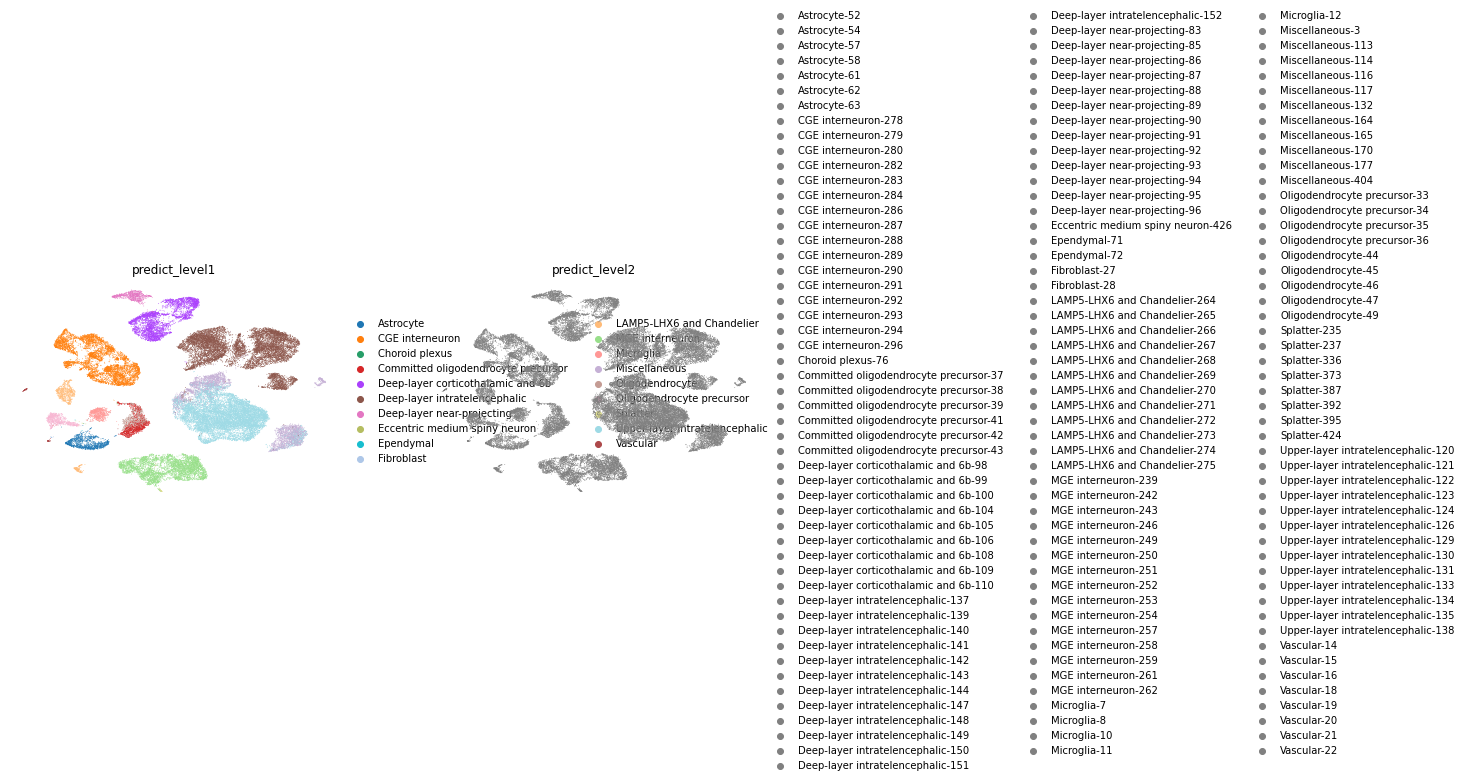

In [ ]:
ad=scAnnot('/home/huang_ziliang/project/brain/data/public/human_brain_MultipleCorticalAreas_AllenBrain_2019_SMART-Seq/h5/ftOutlier_umap.h5ad',show=True)